#  Mathematics of Reinforcement Learning: Homework Sheet 5

## Exercise 1
The theoretical exercise 1 can be found in the PDF file. 

## Exercise 2
In this exercise we use the fixed point approach to compute the value function in the Frozen Lake example. We then use the value function to compute an optimal policy.

Make sure you have all the necessary packages (numpy, gymnasium and matplotlib) installed. You can use `conda install <package>` or `pip install <package>`.

In [1]:
#It may be possible to run the following line of code to install packages:
!pip install gymnasium[toy-text]

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

### Frozen Lake Example

In this homework sheet we use the environment Frozen Lake by Gymnasium (see https://gymnasium.farama.org/environments/toy_text/frozen_lake/). 

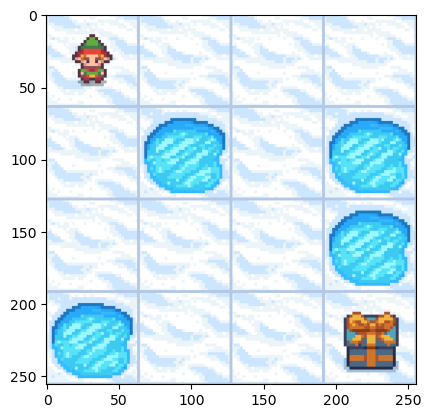

In [3]:
#In the following way an environment env is created:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="rgb_array")

#Visualisation:
env.reset()
plt.imshow(env.render())

#### Short repetition:
The following action and observation spaces are used

| Action space | Observation space |
| --- | --- |
|  `Discrete(4)`| `Discrete(16)`| 

`Discrete(n)` denotes the integers $0,...,n-1$. 

### Action space
The action indicates the direction in which the player is moved. The following encoding is used
* 0: Move left
* 1: Move down
* 2: Move right
* 3: Move up

### Observation space
The observation value represents the players current position on the board.
### Starting state
The starting position is fixed for every map. It is possible to change the map.
### Rewards
The following rewards are used:
* Reaching goal state: +1
* Reaching hole state: 0 
* Any other state: 0

### Episode end
* Termination:
    1. When player moves into a hole
    2. When player reaches the goal
* Truncation:
    1. After 100 timesteps 

# Important changes
**Task 1:** Explain why the Frozen Lake example does not fit our definition of Markov Decision Models.

Instead, we define the following "Twin" Markov Decision Model, which is slightly modified from the Frozen Lake Example. \
Let 
 - $S\coloneqq\{0,1,\dots, 16\}$, where a new state 16 is added. Assume there is a labelling function $m\colon S \to \{$'S','F', 'H', 'G', 'E'$\}$ which labels each state as start state 'S', frozen state 'F', hole state 'H', goal state 'G' or end state 'E'. We assume that only for the newly added state 16 does $m(16)=$'E' hold.  
 - $A\coloneqq\{0,1,2,3\}$, same action space as in the Frozen Lake example.
 - $D\coloneqq S\times A$
 - The transition probability function $p$ is defined as follows:
   * For all states $s\in S$ with $m(s) =$'S' or $m(s)=$'F', use the same transition probability function as in the Frozen Lake example
   * For all states $s\in S$ with $m(s) =$'H' or $m(s) =$'G' set $p(16\mid s,a) = 1$ for all actions $a\in A$
   * For the state $s\in S$ with $m(s) =$'E' set $p(16\mid s,a) = 1$ for all actions $a\in A$
 - For all $a\in A$ the reward function for the state $s\in S$ with $m(s)=$'G' is defined as $r(s,a)\coloneqq 1$, for all other state-action combinations the reward function is set to 0.
 - We add a discounting factor $\gamma \coloneqq 0.95$.

**Task 2:** Argue why optimal policies in this Markov Decision Model are solutions to the Frozen Lake example (assuming that there exists a path).

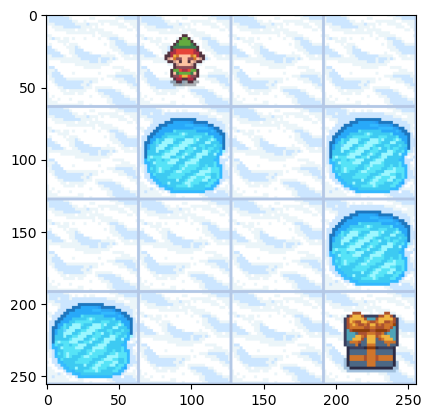

In [4]:
# in the following way maps could be changed.
original_map = ["SFFF", "FHFH", "FFFH", "HFFG"]   #"S" means start, "F" frozen, "H" hole and "G" goal 
alternative_map = ["FSFF", "FHFH", "FFFH", "HFFG"]  #changed start position
env = gym.make('FrozenLake-v1', desc=alternative_map, map_name="4x4", is_slippery=False, render_mode="rgb_array")
env.reset()
plt.imshow(env.render())
plt.show()

**Task 3:** Implement a function `label(s, map)` which takes as input an observation `s` (in the form of an integer) and a map `map` and returns the corresponding label of the state in the map.

In [5]:
def label(s, map):
    map_combined = "".join(map)
    if s == len(map_combined):
        return "E"
    return map_combined[s]

assert label(0, alternative_map) == "F"
assert label(16, original_map) == "E"   #end state should also be implemented

**Task 4:** Implement a function `step(s, a, map)` which takes as input an observation `s`, an action `a` and a map `map` and returns the next observation and a reward following the 'Twin' Markov Decision Model.

In [6]:
def step(s, a, map):
    if s == 16:   # check if end state
        return 16, 0 
    if label(s, map) == "G":  #check if goal state
        return 16, 1
    if label(s, map) == "H": #check if hole state
        return 16, 0
    #the only remaining cases are that the label of the state is either "F" or "S"
    next_state = s
    if a == 0: #move left
        if s%4 != 0:
            next_state = s - 1
    elif a == 1:  #move down
        if s//4 != 3:
            next_state = s + 4
    elif a == 2: #move right
        if s%4 != 3:
            next_state = s+1
    elif a == 3: #move up:
        if s//4 != 0:
            next_state = s-4
    else:
        raise Exception("Something wrong")
    return next_state, 0

assert step(0,0, original_map) == (0,0)
assert step(16,1, original_map) == (16,0)
assert step(15,3, original_map) == (16,1)
assert step(2,2, original_map) == (3,0)

**Task 5:** Implement a function `T(w, map = original_map)` which takes as input a list `w` of length `17` and an optional input `map` and returns a list of length `17` containing the following value at each index `s`
$$ T[w](s)\coloneqq \max_{a\in A(s)}\bigg[r(s,a)+\gamma \sum_{s'\in S}p(s'\mid s,a)w(s')\bigg] $$

In [7]:
gamma = .95 #given by the Markov Decision Model

In [8]:
def T(w, map = original_map):
    output_list = []
    for state in range(len(w)):
        max_value = -np.inf
        for a in range(4):
            next_state, reward = step(state, a, map)
            value_a = reward + gamma * w[next_state]
            if value_a >max_value:
                max_value = value_a
        output_list.append(max_value)
    return output_list


**Task 6:** Implement a function `fixed_point_T()` which approximates the fixed point of the function `T` using the fixed point iteration given by Banach's fixed point theorem.

Start with a random 17-dimensional initial vector $x_0$ (each index uniformly distributed in [0,1]). Compute inductively $x_n = T(x_{n-1})$, for $n\geq 1$. Return the value $x_{10000}$.

In [9]:
def fixed_point_T():
    x = np.random.random(17)
    for _ in range(10000):
        x = T(x)
    return x

fixed_point = fixed_point_T()

assert len(fixed_point) == 17
assert np.isclose(fixed_point[0],0.7350918906249998)
assert np.isclose(fixed_point[-1],0.0)

fixed_point

[0.7350918906249998,
 0.7737809374999999,
 0.8145062499999999,
 0.7737809374999999,
 0.7737809374999999,
 5.708593161249177e-224,
 0.8573749999999999,
 5.708593161249177e-224,
 0.8145062499999999,
 0.8573749999999999,
 0.9025,
 5.708593161249177e-224,
 5.708593161249177e-224,
 0.9025,
 0.95,
 1.0,
 5.708593161249177e-224]

The following code block visualises the fixed point, which is equal to the value function.

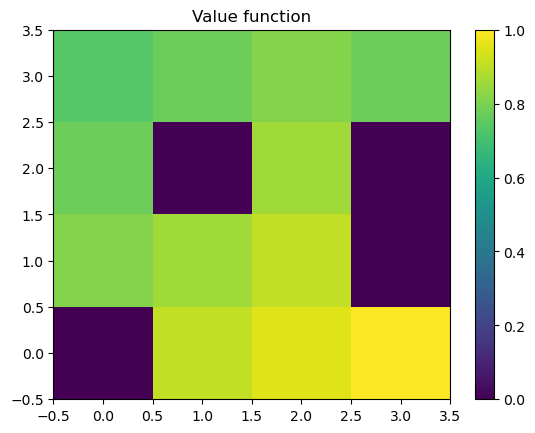

In [10]:
 ### Visualisation section
value_function = np.reshape(fixed_point[:-1],(4,4))

fig, ax = plt.subplots()
c = ax.pcolormesh(np.arange(4), np.arange(4), value_function[::-1])
ax.set_title('Value function')
fig.colorbar(c, ax=ax)
plt.show()

**Task 7:** Implement a function `optimal_policy()` which returns a list of length `16` (we intentionally exclude state 16) and contains at each index the optimal policy given that index as a state. Compute the optimal actions in each state using the Bellman Optimality Equation.

In [11]:
def optimal_policy():
    optimal_action_list = []
    for state in range(16):
        max_value = -np.inf
        opt_a = None
        for a in range(4):
            next_state, reward = step(state, a, original_map)
            value_a = reward + gamma * fixed_point[next_state]
            if value_a > max_value:
                max_value = value_a
                opt_a = a
        optimal_action_list.append(opt_a)
    return optimal_action_list

optimal_policy()

[1, 2, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 2, 2, 0]

The following code block visualises the value function together with the computed optimal actions.

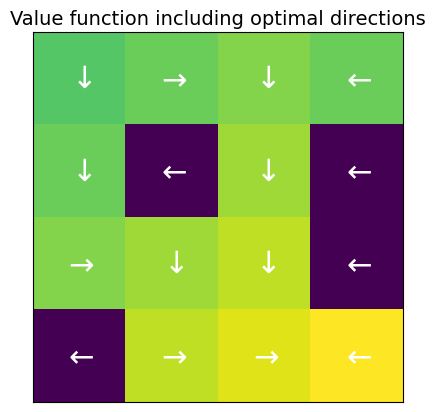

In [12]:
fig, ax = plt.subplots()
im = ax.imshow(value_function)


opt_policy = np.reshape(optimal_policy(),(4,4))
text_matrix = np.zeros((4,4),dtype = '<U13') 
text_matrix[opt_policy == 0] = "$\\leftarrow$"
text_matrix[opt_policy == 1] = "$\\downarrow$"
text_matrix[opt_policy == 2] = "$\\rightarrow$"
text_matrix[opt_policy == 3] = "$\\uparrow$"
# Loop over data dimensions and create text annotations.
for i in range(4):
    for j in range(4):
        text = ax.text(j, i, text_matrix[i, j],
                       ha="center", va="center", color="w", fontdict = {"fontsize" : 22})
ax.set_title("Value function including optimal directions", fontdict = {"fontsize" : 14})
ax.set_xticks([])
ax.set_yticks([])

plt.show()